In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
from operator import itemgetter
import matplotlib.pyplot as plt
%pylab inline
import itertools
import os
import csv

Populating the interactive namespace from numpy and matplotlib


## STRUCTURE

- set sub nodes ( by line at each station )
- set master nodes ( by station )
- link of sub nodes by train
- link of sub nodes by transfer
- link of sub nodes and master nodes by waiting time

### set sub nodes

In [3]:
#Get the station data -
ndata = pd.read_csv("sub_node")

In [4]:
#initialize the graph
#G.clear()
G = nx.MultiDiGraph(name='NYC Subway Network')

In [5]:
#add sub nodes and attributes
for i in range(0,len(ndata)):
    G.add_node(ndata.node_id[i],
               name = ndata.stop_name[i],
               line = ndata['train'][i],
               lat = ndata.stop_lat[i],
               lng = ndata.stop_lon[i],
               geo = (ndata.stop_lon[i],ndata.stop_lat[i]),
               stop_id = ndata.stop_id[i],
               master_node='No',
               master_node_id = ndata.master_node_id[i]
              )

In [6]:
#show the nodes in G
G.nodes(data=True)[:3]

[('625_4',
  {'geo': (-73.951070000000001, 40.785671999999998),
   'lat': 40.785671999999998,
   'line': '4',
   'lng': -73.951070000000001,
   'master_node': 'No',
   'master_node_id': '96 St_1',
   'name': '96 St',
   'stop_id': '625'}),
 ('D25_Q',
  {'geo': (-73.972367000000006, 40.677050000000001),
   'lat': 40.677050000000001,
   'line': 'Q',
   'lng': -73.972367000000006,
   'master_node': 'No',
   'master_node_id': '7 Av_1',
   'name': '7 Av',
   'stop_id': 'D25'}),
 ('625_6',
  {'geo': (-73.951070000000001, 40.785671999999998),
   'lat': 40.785671999999998,
   'line': '6',
   'lng': -73.951070000000001,
   'master_node': 'No',
   'master_node_id': '96 St_1',
   'name': '96 St',
   'stop_id': '625'})]

### set master nodes

In [7]:
#get the master node data and attributes
mdata = pd.read_csv("master_node")

In [8]:
mdata.head()

Unnamed: 0           master_node_id              stop_name   stop_lat  \
0           0                   1 Av_0                   1 Av  40.730953   
1           1  103 St - Corona Plaza_0  103 St - Corona Plaza  40.749865   
2           2                 103 St_0                 103 St  40.799446   
3           3                 103 St_1                 103 St  40.790600   
4           4                 103 St_2                 103 St  40.796092   

    stop_lon stop_id  
0 -73.981628     L06  
1 -73.862700     706  
2 -73.968379     119  
3 -73.947478     624  
4 -73.961454     A18

In [9]:
#add nodes and attributes
for i in range(0,len(mdata)):
    G.add_node(mdata.master_node_id[i],
               name = mdata.stop_name[i],
               master_node='Yes',
               stop_id = mdata.stop_id[i]
              )

In [10]:
G.nodes(data=True)[6:8]

[('138_5',
  {'geo': (-74.012187999999995, 40.711835000000001),
   'lat': 40.711835000000001,
   'line': '5',
   'lng': -74.012187999999995,
   'master_node': 'No',
   'master_node_id': 'Cortlandt St_0',
   'name': 'Cortlandt St',
   'stop_id': '138'}),
 ('Richmond Valley_0',
  {'master_node': 'Yes', 'name': 'Richmond Valley', 'stop_id': 'S13'})]

## link of sub nodes by train

In [11]:
## get edge data
edata = pd.read_csv('duration_7-10am_weekday')

In [12]:
edata.head(3)

Unnamed: 0 from_stop_id to_stop_id train  duration  \
0           0         101S       103S     1      90.0   
1           1         103N       101N     1      90.0   
2           2         103S       104S     1      90.0   

                from_stop_name  from_stop_lat  from_stop_lon  \
0  Van Cortlandt Park - 242 St      40.889248     -73.898583   
1                       238 St      40.884667     -73.900870   
2                       238 St      40.884667     -73.900870   

                  to_stop_name  to_stop_lat  to_stop_lon from_node to_node  
0                       238 St    40.884667   -73.900870     101_1   103_1  
1  Van Cortlandt Park - 242 St    40.889248   -73.898583     103_1   101_1  
2                       231 St    40.878856   -73.904834     103_1   104_1

In [13]:
# #ADD THE EDGES and weighted - method 1
for i in range(0,len(edata.from_node)):
    G.add_edge(edata.from_node[i],edata.to_node[i], 
               weight = edata.duration[i],
               ## attributes
               train = edata.train[i],
               edge_type = 'train')
# # add weighted edges  - method 2
# e= zip(edata.from_node_id,edata.to_node_id,edata.duration)
# G.add_weighted_edges_from(e,train=edata.train)

In [14]:
G.edges(data= True)[:3]

[('136_1', '137_1', {'edge_type': 'train', 'train': '1', 'weight': 80.0}),
 ('136_1', '135_1', {'edge_type': 'train', 'train': '1', 'weight': 60.0}),
 ('138_1', '139_1', {'edge_type': 'train', 'train': '1', 'weight': 90.0})]

### link of sub nodes by transfer

In [15]:
#ADD TRANSFER WITHOUT SWIPE EDGES
tdata = pd.read_csv("transfer")
tdata.head(3)

Unnamed: 0 from_stop_id to_stop_id  min_transfer_time  \
0           0          101        101                180   
1           1          103        103                180   
2           2          104        104                180   

                     from_stop                      to_stop from_train  \
0  Van Cortlandt Park - 242 St  Van Cortlandt Park - 242 St          1   
1                       238 St                       238 St          1   
2                       231 St                       231 St          1   

  to_train from_node_id to_node_id  
0        1        101_1      101_1  
1        1        103_1      103_1  
2        1        104_1      104_1

In [16]:
## adding transfer
for i in range(len(tdata)):
    G.add_edge(tdata.from_node_id[i],tdata.to_node_id[i],
               weight = tdata.min_transfer_time[i],
               ## attributes
               from_train = tdata.from_train[i],
               to_train = tdata.to_train[i],
               edge_type = 'transfer')
    
# ## method 2- add self loop
# e2= zip(tdata.from_stop_id,tdata.to_stop_id,tdata.min_transfer_time)
# G.add_weighted_edges_from(e)

In [17]:
G.edges(data= True)[3:5]

[('136_1',
  '136_2',
  {'edge_type': 'transfer',
   'from_train': '1',
   'to_train': '2',
   'weight': 180}),
 ('136_1', '137_1', {'edge_type': 'train', 'train': '1', 'weight': 80.0})]

### link of sub nodes and master nodes by waiting time

In [18]:
# add waiting time
wdata = pd.read_csv("waiting")
wdata.head(3)

Unnamed: 0 stop_id train                    stop_name   stop_lat  \
0           0     101     1  Van Cortlandt Park - 242 St  40.889248   
1           1     103     1                       238 St  40.884667   
2           2     104     1                       231 St  40.878856   

    stop_lon node_id                 master_node_id  train_num    interval  \
0 -73.898583   101_1  Van Cortlandt Park - 242 St_0       29.0  372.413793   
1 -73.900870   103_1                       238 St_0       33.0  327.272727   
2 -73.904834   104_1                       231 St_0       33.0  327.272727   

      waiting  
0  186.206897  
1  163.636364  
2  163.636364

In [19]:
## adding waiting
for i in range(len(wdata)):
    G.add_edge(wdata.master_node_id[i],wdata.node_id[i],
               weight = wdata.waiting[i],
               ## attributes
               train = wdata.train[i],
               stop_id = wdata.stop_id[i],
               edge_type = 'waiting')
    
# ## method 2- add self loop
# e2= zip(tdata.from_stop_id,tdata.to_stop_id,tdata.min_transfer_time)
# G.add_weighted_edges_from(e)

In [20]:
## adding exit
for i in range(len(wdata)):
    G.add_edge(wdata.node_id[i],wdata.master_node_id[i],
               weight = 0,
               ## attributes
               train = wdata.train[i],
               stop_id = wdata.stop_id[i],
               edge_type = 'exit')
    

## Network Info

In [21]:
print nx.info(G)

Name: NYC Subway Network
Type: MultiDiGraph
Number of nodes: 1378
Number of edges: 5749
Average in degree:   4.1720
Average out degree:   4.1720


In [22]:
master = filter(lambda (n,attr):attr['master_node']=='Yes',G.nodes(data=True))
sub = filter(lambda (n,attr):attr['master_node']=='No',G.nodes(data=True))
print 'number of master nodes:', len(master)
print 'number of sub nodes:', len(sub)

number of master nodes: 465
number of sub nodes: 913


In [23]:
nyc = gpd.read_file('../data/shapefile/nyc_borough_boundry_17b/nybb.shp').to_crs(epsg=4326)

In [24]:
## filter out edges by train and transfer
edges=[]
for (n1,n2,attr) in G.edges(data=True):
    if attr['edge_type'] in ['transfer','train']:
        edges.append((n1,n2))

In [25]:
edges[:4]

[('136_2', '136_2'),
 ('136_2', '136_1'),
 ('136_2', '136_5'),
 ('136_1', '136_2')]

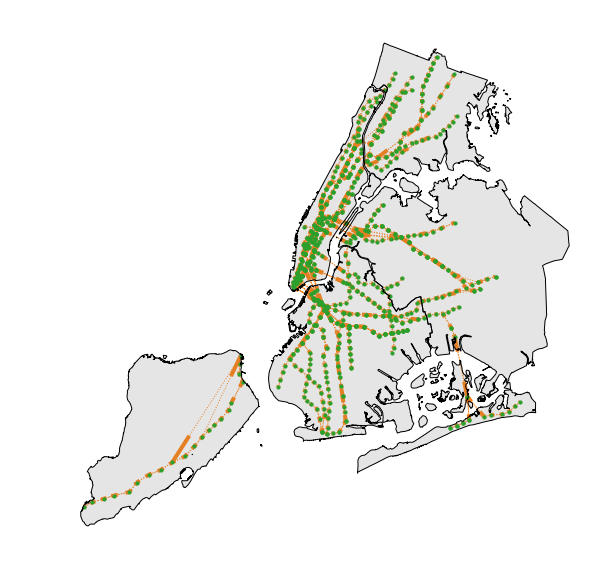

In [26]:
## only plot sub nodes, and edges between sub nodes
plt.figure(figsize=(10,10))
ax= plt.subplot()
nyc.plot(ax=ax,color= 'grey',alpha=0.2)

## filter out sub nodes
sub = filter(lambda (n,attr):attr['master_node']=='No',G.nodes(data=True))

## filter out edges only by transfer and train
edges=[]
for (n1,n2,attr) in G.edges(data=True):
    if attr['edge_type'] in ['transfer','train']:
        edges.append((n1,n2))

location = nx.get_node_attributes(G,'geo')
plt.axis("off")
nx.draw_networkx(G,
                 pos = location,
                 nodelist= map(lambda x:x[0],sub),
                 edgelist = edges,
                 with_labels =False,
                 node_size = 10,
                 style = 'dotted',
                 node_color= 'C2',
                 edge_color= 'C1')

## Centrality

In [23]:
## top 10 betweenness centrallity nodes
sorted(nx.betweenness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:10]

[('R31_N', 0.2531768988857659),
 ('Q01_N', 0.2395409996234279),
 ('R20_N', 0.23746081028835145),
 ('629_4', 0.14109034999004647),
 ('629_5', 0.13271034969466536),
 ('631_4', 0.1256745309016625),
 ('635_4', 0.1256217660366159),
 ('A46_A', 0.12414676918611825),
 ('A51_A', 0.12174139260721849),
 ('631_5', 0.12062206246907635)]

In [24]:
## top 10 betweenness centrallity nodes
important_nodes = sorted(nx.betweenness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:10]
stop_id = map(lambda x: x[0],important_nodes)
stop_name = ndata[ndata['node_id'].isin(stop_id)]['stop_name'].values
print zip(stop_id,stop_name)

[('R31_N', '59 St'), ('Q01_N', 'Grand Central - 42 St'), ('R20_N', '14 St - Union Sq'), ('629_4', '59 St'), ('629_5', 'Grand Central - 42 St'), ('631_4', 'Nostrand Av'), ('635_4', 'Broadway Jct'), ('A46_A', 'Canal St'), ('A51_A', '14 St - Union Sq'), ('631_5', 'Atlantic Av - Barclays Ctr')]


In [31]:
def most_important(G, centrality='betweenness',length=10):
    """
    G is network graph
    centrality could be: betweenness, degree ,closeness
    length = 10 is to select top 10 nodes of highest centrality 
    """
    if centrality == 'betweenness':
        important_nodes = sorted(nx.betweenness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:length]
    if centrality == 'degree':
        important_nodes = sorted(nx.degree_centrality(G).items(),key=lambda x: x[1],reverse=True)[:length]
    if centrality == 'closeness':
        important_nodes = sorted(nx.closeness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:length]
    
    stop_id = map(lambda x: x[0],important_nodes)
    stop_name=[]
    for i in stop_id:
        stop_name.append(ndata[ndata['node_id']==i]['stop_name'].values[0])
        
    ## build up the new network, with only import nodes
    G_important= nx.MultiDiGraph(name='important nodes in NYC Subway Network')
    for i in range(0,length):
        G_important.add_node(stop_id[i],
               name = ndata[ndata['node_id']==stop_id[i]]['stop_name'].values,
               line = ndata[ndata['node_id']==stop_id[i]]['train'].values,
               lat = ndata[ndata['node_id']==stop_id[i]]['stop_lat'].values[0],
               lng = ndata[ndata['node_id']==stop_id[i]]['stop_lon'].values[0],
               geo = (ndata[ndata['node_id']==stop_id[i]]['stop_lon'].values[0],
                      ndata[ndata['node_id']==stop_id[i]]['stop_lat'].values[0])
              )
    # plot the important nodes out
    
    ## base map of nyc
    plt.figure(figsize=(10,10))
    ax= plt.subplot()
    nyc.plot(ax=ax,color= 'grey',alpha=0.2)
    
    # NETWORK
    ## filter out sub nodes
    sub = filter(lambda (n,attr):attr['master_node']=='No',G.nodes(data=True))

    ## filter out edges only by transfer and train
    edges=[]
    for (n1,n2,attr) in G.edges(data=True):
        if attr['edge_type'] in ['transfer','train']:
            edges.append((n1,n2))

    location = nx.get_node_attributes(G,'geo')
    plt.axis("off")
    nx.draw_networkx(G,
                 pos = location,
                 nodelist= map(lambda x:x[0],sub),
                 edgelist = edges,
                 with_labels =False,
                 node_size = 10,
                 style = 'dotted',
                 node_color= 'C2',
                 edge_color= 'C1')
    
    ## the important nodes
    location_I = nx.get_node_attributes(G_important,'geo')
    nx.draw_networkx(G_important,
                 pos = location_I,
                 with_labels =False,
                 node_size = 40,
                 style = 'dotted',
                 node_color= 'C3',
                 edge_color= 'C1',
                 alpha=0.8)
    
    return zip(range(1,length+1),stop_name,stop_id)

[(1, 'Atlantic Av - Barclays Ctr', 'R31_N'),
 (2, 'Canal St', 'Q01_N'),
 (3, '14 St - Union Sq', 'R20_N'),
 (4, '59 St', '629_4'),
 (5, '59 St', '629_5')]

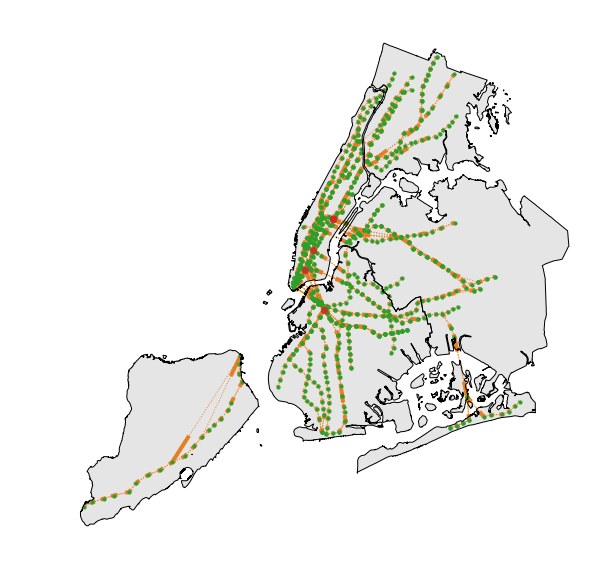

In [32]:
most_important(G,'betweenness',5)

In [ ]:
most_important(G,'closeness',5)

In [ ]:
most_important(G,'degree',5)

## Dijkstra-- Shortest Path

In [23]:
master_nodes = map(lambda x: x[0], master)

In [22]:
from_master=[]
to_master = []
for i,j in itertools.permutations(master_nodes,2):
    from_master.append(i)
    to_master.append(j)

In [24]:
whole_network = pd.DataFrame(zip(from_master,to_master),columns=['from_master','to_master'])

In [25]:
whole_network['shortest_path']= None
whole_network['duration']= None

In [ ]:
nopath=[]
#for i in range(10):
for i in range(len(whole_network)):
    from_master_id = whole_network.loc[i,'from_master']
    to_master_id = whole_network.loc[i,'to_master']
    try:
        shortest_path = ','.join(nx.shortest_path(G,from_master_id,to_master_id,weight= 'weight'))
        duration = nx.shortest_path_length(G,from_master_id,to_master_id,weight='weight')
        whole_network.loc[i,'shortest_path']= shortest_path
        whole_network.loc[i,'duration']= duration
        
    except:
        nopath.append((from_master_id,to_master_id))

In [ ]:
len(master_nodes)*(len(master_nodes)-1)

In [35]:
whole_network.to_csv('whole_network')

## REMOVE NODES FROM NETWORK

In [23]:
whole_network=pd.read_csv('whole_network',index_col=0)

In [24]:
whole_network = whole_network.dropna().reset_index(drop= True)

In [25]:
whole_network.head()

from_master                     to_master  \
0  Grant Av_0  Atlantic Av - Barclays Ctr_0   
1  Grant Av_0                      169 St_0   
2  Grant Av_0                  Neptune Av_0   
3  Grant Av_0            Jamaica - 179 St_0   
4  Grant Av_0                  Bedford Av_0   

                                       shortest_path     duration  
0  Grant Av_0,A57_A,A55_A,A51_A,A48_A,A46_A,A42_A...  1935.622120  
1  Grant Av_0,A57_A,A55_A,A51_A,J27_J,J24_J,J23_J...  3410.687055  
2  Grant Av_0,A57_A,A55_A,A51_A,A48_A,A48_C,A47_C...  3397.050691  
3  Grant Av_0,A57_A,A55_A,A51_A,J27_J,J24_J,J23_J...  3635.687055  
4  Grant Av_0,A57_A,A55_A,A51_A,Broadway Jct_0,L2...  2002.050691

In [24]:
def find_sub_nodes(master_node_id):
    """
    master_node_id =[...]
    if master node is removed, find related master node
    should pass a list of master nodes to this function
    """
    
    
    removed_sub_nodes=[]
    for (n,attr) in G.nodes(data = True):
        try:
            if attr['master_node_id'] in master_node_id:
                removed_sub_nodes.append(n)
        except KeyError:
            pass
    return set(removed_sub_nodes)

In [25]:
def find_affected_od_index(master_node_id):
    """
    find affected o-d pair given a list of a master_node_id
    """
    removed_sub_nodes = find_sub_nodes(master_node_id)
    affected_od_index =[]
    for i in range(len(whole_network)):
        if len(removed_sub_nodes & set(whole_network.loc[i,'shortest_path'].split(','))) == 0:
            pass
        else:
            affected_od_index.append(i)
    return affected_od_index

In [26]:
def calculate_duration_2(removed_master_node):
    
    removed_sub_nodes = find_sub_nodes([removed_master_node])
    
    G_0 = G.copy()
    G_0.remove_nodes_from(removed_sub_nodes)
    dict_duration  = nx.all_pairs_dijkstra_path_length(G_0)
    df = pd.DataFrame.from_dict(dict_duration)
    df.index.name='to_master_id'
    
    ### some error raises ,eg: 'Jamaica Center - Parsons/Archer_0' cannot save to csv
    ### so change / into -
    removed_master_node = removed_master_node.replace('/','-')
    df.loc[master_nodes,master_nodes].to_csv('remove-one-node/'+removed_master_node)
    return dict_duration


In [30]:
t1= datetime.datetime.now()
removed_master_node= 'Grant Av_0'
calculate_duration_2(removed_master_node)
t2 = datetime.datetime.now()-t1
print t2

0:00:30.230374


In [44]:
## error raise here
master_nodes[141]

'Jamaica Center - Parsons/Archer_0'

In [32]:
len(os.listdir('remove-one-node'))

357

In [29]:
master_nodes[141]

'Jamaica Center - Parsons/Archer_0'

In [36]:
for i,j in enumerate(master_nodes[1:]):
    j = j.replace('/','-')
    if j in os.listdir('remove-one-node')[1:]:
#         pass
#     else:
        print i,j
        break

109 Brighton Beach_0


In [ ]:
for i in range(1,110):
    removed_master_node= master_nodes[i]
    calculate_duration_2(removed_master_node)

In [220]:
len(os.listdir('remove-one-node'))

466

In [52]:
## calculate whole network shortest path length
dict_duration = nx.all_pairs_dijkstra_path_length(G,weight='weight')
df = pd.DataFrame.from_dict(dict_duration)
df.index.name='to_master_id'

In [55]:
df.loc[master_nodes,master_nodes].to_csv('whole_network_duration')

In [57]:
df.loc[master_nodes,master_nodes].head(2)

Grant Av_0  Atlantic Av - Barclays Ctr_0  \
to_master_id                                                             
Grant Av_0                       0.00000                   1651.764706   
Atlantic Av - Barclays Ctr_0  1935.62212                      0.000000   

                              Richmond Valley_0     169 St_0  Neptune Av_0  \
to_master_id                                                                 
Grant Av_0                                  NaN  2835.872710        3262.5   
Atlantic Av - Barclays Ctr_0                NaN  3413.823529        2040.0   

                              Jamaica - 179 St_0  Bedford Av_0  \
to_master_id                                                     
Grant Av_0                           2945.685544   1696.140089   
Atlantic Av - Barclays Ctr_0         3523.636364   1489.090909   

                              63 Dr - Rego Park_0  Junction Blvd_0  \
to_master_id                                                         
Grant Av_0                            2821.831789      3111.692037   
Atlantic Av - Barclays Ctr_0          2992.567222      2507.142857   

                                  40 St_0           ...            \
to_master_id                                        ...             
Grant Av_0                    2795.483760           ...             
Atlantic Av - Barclays Ctr_0  2190.934579           ...             

                              Beach 105 St_0  Morris Park_0  Allerton Av_0  \
to_master_id                                                                 
Grant Av_0                       2212.500000    4773.001521    5073.586887   
Atlantic Av - Barclays Ctr_0     3973.928571    3714.372003    4014.957369   

                              5 Av/59 St_0  Aqueduct - N Conduit Av_0  \
to_master_id                                                            
Grant Av_0                     2820.566802                 880.887097   
Atlantic Av - Barclays Ctr_0   1568.461538                2642.315668   

                              Old Town_0  Houston St_0  Hunters Point Av_0  \
to_master_id                                                                 
Grant Av_0                           NaN   2318.571429         2563.105518   
Atlantic Av - Barclays Ctr_0         NaN   1448.571429         1739.611399   

                                  39 Av_0  Mets - Willets Point_0  
to_master_id                                                       
Grant Av_0                    2751.258041             3323.381297  
Atlantic Av - Barclays Ctr_0  2146.708861             2718.832117  

[2 rows x 465 columns]

## CALCULATE INFLUENCE OF REMOVING ONE NODE

In [171]:
odpair=[]
for i in itertools.product(whole_network_duration[0,1:],repeat=2):
    odpair.append(i)

In [181]:
## x[0] is to_master_id, x[1] is from_master_id
odpair[:5]

[('Grant Av_0', 'Grant Av_0'),
 ('Grant Av_0', 'Atlantic Av - Barclays Ctr_0'),
 ('Grant Av_0', 'Richmond Valley_0'),
 ('Grant Av_0', '169 St_0'),
 ('Grant Av_0', 'Neptune Av_0')]

In [145]:
## for the first column of the whole difference df
whole_network_duration = np.array(list(csv.reader(open("whole_network_duration", "rb"), delimiter=",")))
df=np.array(list(csv.reader(open("remove-one-node/"+master_nodes[110], "rb"), delimiter=",")))
if (whole_network_duration[:,0] == df[:,0]).all() & (whole_network_duration[0,:] == df[0,:]).all() :
    df_0= whole_network_duration[1:,1:]
    df_0[df_0=='']=np.nan
    df_0 = df_0.astype('float')
    
    df = df[1:,1:]
    df[df=='']=np.nan
    df = df.astype('float')
    difference=(df-df_0).flatten()
    df_diff = pd.DataFrame.from_dict({master_nodes[110]:dict(zip(odpair,difference))})

In [234]:
## for whole difference df
for i in range(465):
    file_name = master_nodes[i].replace('/','-')
    df=np.array(list(csv.reader(open("remove-one-node/"+file_name, "rb"), delimiter=",")))
    if (whole_network_duration[:,0] == df[:,0]).all() & (whole_network_duration[0,:] == df[0,:]).all() :
        df_0= whole_network_duration[1:,1:]
        df_0[df_0=='']=np.nan
        df_0 = df_0.astype('float')
    
        df = df[1:,1:]
        df[df=='']=np.nan
        df = df.astype('float')
        difference=(df-df_0).flatten()
        df_diff_1 = pd.DataFrame.from_dict({master_nodes[i]:dict(zip(odpair,difference))})
        df_diff = df_diff.join(df_diff_1)

In [227]:
df_diff.head()

Brighton Beach_0  Canal St_1  Canal St_0  \
1 Av_0 1 Av_0                                0.0         0.0         0.0   
       103 St - Corona Plaza_0               0.0         0.0         0.0   
       103 St_0                              0.0         0.0         0.0   
       103 St_1                              0.0         0.0         0.0   
       103 St_2                              0.0         0.0         0.0   

                                Canal St_2  Intervale Av_0  65 St_0  \
1 Av_0 1 Av_0                          0.0             0.0      0.0   
       103 St - Corona Plaza_0         0.0             0.0      0.0   
       103 St_0                        0.0             0.0      0.0   
       103 St_1                        0.0             0.0      0.0   
       103 St_2                        0.0             0.0      0.0   

                                Parkside Av_0  Broad Channel_0  \
1 Av_0 1 Av_0                             0.0              0.0   
       103 St - Corona Plaza_0            0.0              0.0   
       103 St_0                           0.0              0.0   
       103 St_1                           0.0              0.0   
       103 St_2                           0.0              0.0   

                                34 St - Penn Station_1  \
1 Av_0 1 Av_0                                 0.000000   
       103 St - Corona Plaza_0                0.000000   
       103 St_0                               0.000000   
       103 St_1                               0.000000   
       103 St_2                             235.120482   

                                34 St - Penn Station_0  \
1 Av_0 1 Av_0                                 0.000000   
       103 St - Corona Plaza_0                0.000000   
       103 St_0                              25.120482   
       103 St_1                               0.000000   
       103 St_2                               0.000000   

                                         ...            Beach 105 St_0  \
1 Av_0 1 Av_0                            ...                       0.0   
       103 St - Corona Plaza_0           ...                       0.0   
       103 St_0                          ...                       0.0   
       103 St_1                          ...                       0.0   
       103 St_2                          ...                       0.0   

                                Morris Park_0  Allerton Av_0  5 Av/59 St_0  \
1 Av_0 1 Av_0                             0.0            0.0           0.0   
       103 St - Corona Plaza_0            0.0            0.0           0.0   
       103 St_0                           0.0            0.0           0.0   
       103 St_1                           0.0            0.0           0.0   
       103 St_2                           0.0            0.0           0.0   

                                Aqueduct - N Conduit Av_0  Old Town_0  \
1 Av_0 1 Av_0                                         0.0         0.0   
       103 St - Corona Plaza_0                        0.0         0.0   
       103 St_0                                       0.0         0.0   
       103 St_1                                       0.0         0.0   
       103 St_2                                       0.0         0.0   

                                Houston St_0  Hunters Point Av_0  39 Av_0  \
1 Av_0 1 Av_0                            0.0            0.000000      0.0   
       103 St - Corona Plaza_0           0.0            9.065421      0.0   
       103 St_0                          0.0            0.000000      0.0   
       103 St_1                          0.0            0.000000      0.0   
       103 St_2                          0.0            0.000000      0.0   

                                Mets - Willets Point_0  
1 Av_0 1 Av_0                                      0.0  
       103 St - Corona Plaza_0                     0.0  
       103 St_0                                    0.0  
       10

In [260]:
len(df_diff.columns) 

467

In [243]:
pd.read_csv('remove_one_node_duration',
            compression='gzip').rename(columns= {'Unnamed: 0':'to_master_id',
                                                'Unnamed: 1':'from_master_id'}).to_csv('remove_one_node_duration.csv.gz',
                                                                                       compression='gzip')

In [248]:
df_diff = pd.read_csv('remove_one_node_duration.csv.gz',compression='gzip',index_col=0)

In [250]:
df_diff = df_diff[df_diff['from_master_id']!= df_diff['to_master_id']]

In [256]:
df_diff.to_csv('remove_one_node_duration')

In [257]:
df_diff.to_csv('remove_one_node_duration.csv.gz',compression='gzip')

In [258]:
os.stat('remove_one_node_duration').st_size

392126776

In [259]:
os.stat('remove_one_node_duration.csv.gz').st_size

10054819

## remove 2 nodes in the network , calculate the duration

In [27]:
def calculate_duration_remove2nodes(removed_master_node):
    """
    removed_master_node = [...]
    a list of master nodes to be removed
    this function is to calculate shortest path length of new network without multi-nodes
    """
    removed_sub_nodes = find_sub_nodes(removed_master_node)
    
    G_0 = G.copy()
    G_0.remove_nodes_from(removed_sub_nodes)
    dict_duration  = nx.all_pairs_dijkstra_path_length(G_0)
    df = pd.DataFrame.from_dict(dict_duration)
    df.index.name='to_master_id'
    
    ### some error raises ,eg: 'Jamaica Center - Parsons/Archer_0' cannot save to csv
    ### so change / into -
    filename = ','.join(removed_master_node)
    filename = filename.replace('/','-')
    df.loc[master_nodes,master_nodes].to_csv('remove-two-node/'+filename)
    return dict_duration


In [170]:
t1= datetime.datetime.now()
removed_master_node= ['Canal St_0','Times Sq - 42 St_0']
calculate_duration_remove2nodes(removed_master_node)
t2 = datetime.datetime.now()-t1
print t2

0:00:31.622143


## Get the removed pair

In [63]:
bwt_centrality = nx.betweenness_centrality(G,weight ='weight')

In [91]:
bwt_centrality.items()[:4]

[('Grant Av_0', 0.0),
 ('Atlantic Av - Barclays Ctr_0', 0.0),
 ('136_2', 0.0),
 ('136_1', 0.006137891203785147)]

#### As master node are only connected to the sub-nodes in the station, so no shortest path go through it. Then master nodes' betweenness centrality are all 0.

In [36]:
degree = nx.degree(G)

In [37]:
degree_0=degree.copy()

In [38]:
degree = filter(lambda (x,y): x in master_nodes,
       sorted(degree.iteritems(), key=lambda (k,v): (v,k),reverse =True))

In [39]:
removed_pair_1 = []
for pair in itertools.combinations(map(lambda x:x[0], degree[:50]),2):
    #pair = tuple([x.replace('/','-') for x in pair])
    removed_pair_1.append(pair)

In [40]:
highest_degree_master = map(lambda x:x[0], degree[:100])
removed_pair_2 = []
for pair in itertools.combinations(highest_degree_master,2):
    #pair = tuple([x.replace('/','-') for x in pair])
    removed_pair_2.append(pair)

In [41]:
removed_pair = filter( lambda x: x not in removed_pair_1, removed_pair_2)

In [43]:
removed_pair[:2]

[('Atlantic Av - Barclays Ctr_0', '42 St - Port Authority Bus Terminal_0'),
 ('Atlantic Av - Barclays Ctr_0', '36 St_0')]

In [ ]:
for removed_master_node in removed_pair:
    calculate_duration_remove2nodes(removed_master_node)

In [87]:
len(os.listdir('remove-two-node/'))

2350

## CRITICAL

In [28]:
delay = pd.read_csv('delay_one_node_removal',index_col=0)
critical_nodes =delay.head(50)['station'].values

In [29]:
critical_pairs=[]
for i in itertools.combinations([x.replace('/','-') for x in critical_nodes],2):
    critical_pairs.append(i)

In [30]:
len(critical_pairs)

1225

In [31]:
filter (lambda x :'/' in x, critical_nodes)

['Lexington Av/63 St_0', '5 Av/53 St_0']

In [32]:
removed_pair = map(lambda x: (x[0].replace('Lexington Av-63 St_0','Lexington Av/63 St_0'),
               x[1].replace('Lexington Av-63 St_0','Lexington Av/63 St_0')), critical_pairs)

In [33]:
removed_pair = map(lambda x: (x[0].replace('5 Av-53 St_0','5 Av/53 St_0'),
               x[1].replace('5 Av-53 St_0','5 Av/53 St_0')), removed_pair)

In [34]:
removed_pair[:3]

[('Jackson Hts - Roosevelt Av_0', '149 St - Grand Concourse_0'),
 ('Jackson Hts - Roosevelt Av_0', '125 St_2'),
 ('Jackson Hts - Roosevelt Av_0', 'Broadway Jct_0')]

In [ ]:
for removed_master_node in removed_pair[515:]:
    calculate_duration_remove2nodes(removed_master_node)

In [37]:
len(os.listdir('remove-two-node'))

1225

## duration difference of removing 2 node

In [45]:
pd.read_csv('whole_network_duration').head()

to_master_id   Grant Av_0  Atlantic Av - Barclays Ctr_0  \
0                    Grant Av_0     0.000000                   1651.764706   
1  Atlantic Av - Barclays Ctr_0  1935.622120                      0.000000   
2             Richmond Valley_0          NaN                           NaN   
3                      169 St_0  3410.687055                   3341.000000   
4                  Neptune Av_0  3397.050691                   2111.162791   

   Richmond Valley_0     169 St_0  Neptune Av_0  Jamaica - 179 St_0  \
0                NaN  2835.872710        3262.5         2945.685544   
1                NaN  3413.823529        2040.0         3523.636364   
2                0.0          NaN           NaN                 NaN   
3                NaN     0.000000        5161.5          268.636364   
4                NaN  5205.872710           0.0         5315.685544   

   Bedford Av_0  63 Dr - Rego Park_0  Junction Blvd_0           ...            \
0   1696.140089          2821.831789      3111.692037           ...             
1   1489.090909          2992.567222      2507.142857           ...             
2           NaN                  NaN              NaN           ...             
3   2458.090909          1044.782609      1497.142857           ...             
4   3139.090909          4846.400491      4194.642857           ...             

   Beach 105 St_0  Morris Park_0  Allerton Av_0  5 Av/59 St_0  \
0     2212.500000    4773.001521    5073.586887   2820.566802   
1     3973.928571    3714.372003    4014.957369   1568.461538   
2             NaN            NaN            NaN           NaN   
3     5448.993506    4296.751521    4597.336887   2067.461538   
4     5435.357143    5634.372003    5934.957369   3488.461538   

   Aqueduct - N Conduit Av_0   Old Town_0  Houston St_0  Hunters Point Av_0  \
0                 880.887097          NaN   2318.571429         2563.105518   
1                2642.315668          NaN   1448.571429         1739.611399   
2                        NaN  2068.421053           NaN                 NaN   
3                4117.380603          NaN   2803.304587         1795.056338   
4                4103.744240          NaN   3413.571429         3646.056338   

       39 Av_0  Mets - Willets Point_0  
0  2751.258041             3323.381297  
1  2146.708861             2718.832117  
2          NaN                     NaN  
3  1983.208861             1708.832117  
4  3834.208861             4406.332117  

[5 rows x 466 columns]

In [43]:
whole_network_duration = np.array(list(csv.reader(open("whole_network_duration", "rb"),
                                                  delimiter=",")))

In [44]:
odpair=[]
for i in itertools.product(whole_network_duration[0,1:],repeat=2):
    odpair.append(i)

In [46]:
## x[0] is to_master_id, x[1] is from_master_id
odpair[:5]

[('Grant Av_0', 'Grant Av_0'),
 ('Grant Av_0', 'Atlantic Av - Barclays Ctr_0'),
 ('Grant Av_0', 'Richmond Valley_0'),
 ('Grant Av_0', '169 St_0'),
 ('Grant Av_0', 'Neptune Av_0')]

In [47]:
df_diff=pd.DataFrame()

In [48]:
for file_name in os.listdir('remove-two-node')[:1]:
    df=np.array(list(csv.reader(open("remove-two-node/"+file_name, "rb"), delimiter=",")))
    if (whole_network_duration[:,0] == df[:,0]).all() & (whole_network_duration[0,:] == df[0,:]).all() :
        df_0= whole_network_duration[1:,1:]
        df_0[df_0=='']=np.nan
        df_0 = df_0.astype('float')
    
        df = df[1:,1:]
        df[df=='']=np.nan
        df = df.astype('float')
        difference=(df-df_0).flatten()
        df_diff= pd.DataFrame.from_dict({file_name:dict(zip(odpair,difference))})
        #df_diff = df_diff.join(df_diff_1)

In [163]:
file_name

'Pennsylvania Av_0,DeKalb Av_0'

In [49]:
for file_name in os.listdir('remove-two-node')[1:]:
    df=np.array(list(csv.reader(open("remove-two-node/"+file_name, "rb"), delimiter=",")))
    if (whole_network_duration[:,0] == df[:,0]).all() & (whole_network_duration[0,:] == df[0,:]).all() :
        df_0= whole_network_duration[1:,1:]
        df_0[df_0=='']=np.nan
        df_0 = df_0.astype('float')
    
        df = df[1:,1:]
        df[df=='']=np.nan
        df = df.astype('float')
        difference=(df-df_0).flatten()
        df_diff_1 = pd.DataFrame.from_dict({file_name:dict(zip(odpair,difference))})
        df_diff = df_diff.join(df_diff_1)

In [50]:
len(df_diff.columns)

1225

In [51]:
df_diff.to_csv('remove_two_nodes_duration.csv.gz',compression='gzip')

In [52]:
os.stat('remove_two_nodes_duration.csv.gz').st_size

37637938

In [56]:
df_diff= df_diff.fillna(3600)

In [57]:
df_diff= df_diff.reset_index().rename(columns={'level_0':'to_master_id',
                                     'level_1':'from_master_id'})

In [58]:
df_diff = df_diff[df_diff['from_master_id']!= df_diff['to_master_id']]

In [59]:
df_diff.head()

to_master_id           from_master_id  \
1       1 Av_0  103 St - Corona Plaza_0   
2       1 Av_0                 103 St_0   
3       1 Av_0                 103 St_1   
4       1 Av_0                 103 St_2   
5       1 Av_0                 104 St_0   

   Jackson Hts - Roosevelt Av_0,125 St_2  \
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   
5                                    0.0   

   E 180 St_0,59 St - Columbus Circle_0  E 180 St_0,34 St - Penn Station_1  \
1                               0.00000                           0.000000   
2                               0.00000                           0.000000   
3                               0.00000                           0.000000   
4                            1353.69403                         235.120482   
5                               0.00000                           0.000000   

   Jackson Hts - Roosevelt Av_0,3 Av - 149 St_0  E 180 St_0,Whitehall St_0  \
1                                           0.0                        0.0   
2                                           0.0                        0.0   
3                                           0.0                        0.0   
4                                           0.0                        0.0   
5                                           0.0                        0.0   

   Jackson Hts - Roosevelt Av_0,3 Av - 138 St_0  80 St_0,86 St_1  \
1                                           0.0          0.00000   
2                                           0.0          0.00000   
3                                           0.0       1242.30179   
4                                           0.0          0.00000   
5                                           0.0       3600.00000   

   Jackson Hts - Roosevelt Av_0,72 St_2         ...           \
1                                   0.0         ...            
2                                   0.0         ...            
3                                   0.0         ...            
4                                   0.0         ...            
5                                   0.0         ...            

   14 St - Union Sq_0,168 St - Washington Hts_0  Franklin Av_1,Broadway_1  \
1                                    116.565421                       0.0   
2                                      0.000000                       0.0   
3                                    489.095745                       0.0   
4                                      0.000000                       0.0   
5                                      0.000000                       0.0   

   42 St - Port Authority Bus Terminal_0,86 St_4  Franklin Av_1,Church Av_0  \
1                                       0.000000                        0.0   
2                                       0.000000                        0.0   
3                                       0.000000                        0.0   
4                                     235.120482                        0.0   
5                                       0.000000                        0.0   

   42 St - Port Authority Bus Terminal_0,E 180 St_0  \
1                                          0.000000   
2                                          0.000000   
3                                          0.000000   
4                                        235.120482   
5                                          0.000000   

   42 St - Port Authority Bus Terminal_0,88 St_0  \
1                                       0.000000   
2                                       0.000000   
3                                       0.000000   
4                                     235.120482   
5                                    3600.000000   

   Franklin Av_1,Whitehall St_0  Atlantic Av - Barclays Ctr_0,30 Av_0  \
1                           0.0                                   0.0   
2                 

In [60]:
len(df_diff)

215760

## TWO NODES CRITICIALITY 

In [61]:
demand_0 = pd.read_csv('demand.csv.gz',compression='gzip',index_col=0)

In [109]:
### if none, means not reachable for 1 hour
df_diff = df_diff.fillna(3600)

In [62]:
df_diff_0 = df_diff.merge(demand_0,on = ['to_master_id','from_master_id'])

In [63]:
delay = {}
for pair in df_diff_0.columns[2:-1]:
    delay[pair]= sum(np.array(df_diff_0.loc[:,pair]) * np.array(df_diff_0.loc[:,'demand']))


In [64]:
df_diff_0.iloc[:5]

to_master_id           from_master_id  \
0       1 Av_0  103 St - Corona Plaza_0   
1       1 Av_0                 103 St_0   
2       1 Av_0                 103 St_1   
3       1 Av_0                 103 St_2   
4       1 Av_0                 104 St_0   

   Jackson Hts - Roosevelt Av_0,125 St_2  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   E 180 St_0,59 St - Columbus Circle_0  E 180 St_0,34 St - Penn Station_1  \
0                               0.00000                           0.000000   
1                               0.00000                           0.000000   
2                               0.00000                           0.000000   
3                            1353.69403                         235.120482   
4                               0.00000                           0.000000   

   Jackson Hts - Roosevelt Av_0,3 Av - 149 St_0  E 180 St_0,Whitehall St_0  \
0                                           0.0                        0.0   
1                                           0.0                        0.0   
2                                           0.0                        0.0   
3                                           0.0                        0.0   
4                                           0.0                        0.0   

   Jackson Hts - Roosevelt Av_0,3 Av - 138 St_0  80 St_0,86 St_1  \
0                                           0.0          0.00000   
1                                           0.0          0.00000   
2                                           0.0       1242.30179   
3                                           0.0          0.00000   
4                                           0.0       3600.00000   

   Jackson Hts - Roosevelt Av_0,72 St_2   ...    Franklin Av_1,Broadway_1  \
0                                   0.0   ...                         0.0   
1                                   0.0   ...                         0.0   
2                                   0.0   ...                         0.0   
3                                   0.0   ...                         0.0   
4                                   0.0   ...                         0.0   

   42 St - Port Authority Bus Terminal_0,86 St_4  Franklin Av_1,Church Av_0  \
0                                       0.000000                        0.0   
1                                       0.000000                        0.0   
2                                       0.000000                        0.0   
3                                     235.120482                        0.0   
4                                       0.000000                        0.0   

   42 St - Port Authority Bus Terminal_0,E 180 St_0  \
0                                          0.000000   
1                                          0.000000   
2                                          0.000000   
3                                        235.120482   
4                                          0.000000   

   42 St - Port Authority Bus Terminal_0,88 St_0  \
0                                       0.000000   
1                                       0.000000   
2                                       0.000000   
3                                     235.120482   
4                                    3600.000000   

   Franklin Av_1,Whitehall St_0  Atlantic Av - Barclays Ctr_0,30 Av_0  \
0                           0.0                                   0.0   
1                           0.0                                   0.0   
2                           0.0                                   0.0   
3                           0.0                                   0.0   
4                           0.0                                   0.0   

   Franklin Av_1,88 St_0  36 St_0,Euclid Av_0  demand  
0                    0.0                  0.0    70.0 

In [66]:
delay = pd.DataFrame(sorted(delay.items(), key=lambda x: x[1],reverse=True),columns=['station','delay'])

In [68]:
delay.to_csv('delay_two_nodes_removal')